<a href="https://colab.research.google.com/github/jackseg80/cryptoBot_2023/blob/master/backtest/single_coin/bol_trend/bol_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H3>Stratégie Bollinger Trend</H3>
Indicateurs: bande de Bollinger + moyenne mobile long terme<br>
SEG

In [1]:
import sys
sys.path.append('../../..')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import get_n_columns
from utilities.futur_simulations import plot_futur_simulations, plot_train_test_simulation
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np

In [2]:
# Stratégie Bollinger Trend - Backtest
class BolTrend():
    def __init__(
        self,
        df,
        type=["long"],
        bol_window = 100,
        bol_std = 2.25,
        min_bol_spread = 0,
        long_ma_window = 500,
    ):
        self.df = df
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.bol_window = bol_window
        self.bol_std = bol_std
        self.min_bol_spread = min_bol_spread
        self.long_ma_window = long_ma_window

        
    def populate_indicators(self):
        # -- Clear dataset --
        # Les colonnes du jeu de données qui ne sont pas "open", "high", "low", "close" ou "volume" sont supprimées
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
        
        # -- Populate indicators --
        bol_band = ta.volatility.BollingerBands(close=df["close"], window=int(self.bol_window), window_dev=int(self.bol_std))
        df["lower_band"] = bol_band.bollinger_lband()
        df["higher_band"] = bol_band.bollinger_hband()
        df["ma_band"] = bol_band.bollinger_mavg()

        df['long_ma'] = ta.trend.sma_indicator(close=df['close'], window=int(self.long_ma_window))

        df = get_n_columns(df, ["ma_band", "lower_band", "higher_band", "close"], 1)
        
        self.df = df    
        return self.df
    
    def populate_buy_sell(self): 
        df = self.df
        # -- Initiate populate --
        df["open_long_market"] = False
        df["close_long_market"] = False
        df["open_short_market"] = False
        df["close_short_market"] = False
        
        if self.use_long:
            # -- Populate open long market --
            df.loc[
                (df['n1_close'] < df['n1_higher_band']) 
                & (df['close'] > df['higher_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_bol_spread)
                & (df["close"] > df["long_ma"]) 
                , "open_long_market"
            ] = True
        
            # -- Populate close long market --
            df.loc[
                (df['close'] < df['ma_band']) 
                , "close_long_market"
            ] = True

        if self.use_short:
            # -- Populate open short market --
            df.loc[
                (df['n1_close'] > df['n1_lower_band']) 
                & (df['close'] < df['lower_band']) 
                & ((df['n1_higher_band'] - df['n1_lower_band']) / df['n1_lower_band'] > self.min_bol_spread)
                & (df["close"] < df["long_ma"])
                , "open_short_market"
            ] = True
        
            # -- Populate close short market --
            df.loc[
                (df['close'] > df['ma_band']) 
                , "close_short_market"
            ] = True
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, leverage=1, maker_fee=0.0002, taker_fee=0.0007):
        df = self.df[:]
        wallet = initial_wallet
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None

        for index, row in df.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    elif current_position['side'] == "SHORT":
                        close_price = row['close']
                        trade_result = (current_position['price'] - close_price) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day
            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     
                    # -- Close LONG market --
                    if row['close_long_market']:
                        close_price = row['close']
                        trade_result = ((close_price - current_position['price']) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None
                        
                elif current_position['side'] == "SHORT":
                    # -- Close SHORT Market --
                    if row['close_short_market']:
                        close_price = row['close']
                        trade_result = ((current_position['price'] - close_price) / current_position['price']) * leverage
                        wallet += wallet * trade_result
                        fee = wallet * taker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "SHORT",
                            "open_reason": current_position['reason'],
                            "close_reason": "Market",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size": current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # -- Open long Market --
                if row['open_long_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                elif row['open_short_market']:
                    open_price = row['close']
                    fee = wallet * taker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Market",
                        "side": "SHORT"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        if df_trades.empty:
            print("!!! No trades")
            return None
        else:
            df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
            df_trades = df_trades.set_index(df_trades['open_date'])  
        
        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days
        }       
        

In [3]:
# Choix de la paire à trader et du temps des bougies
pair = "ETH/USDT"
tf = "1h"

df = get_historical_from_db(
    ccxt.binance(), 
    pair,
    tf,
    path="../../../database/"
)

Période: [2018-01-01 00:00:00] -> [2023-01-11 00:00:00]
Portefeuille initial: 1000.0

--- Informations Générales ---
Portefeuille final: 567269.33
Performance vs US dollar: 56626.93 %
Pire Drawdown T|D: -26.43% | -31.95%
Buy and hold performance: 83.85 %
Performance vs buy and hold: 30754.53 %
Nombre total de trades sur la période: 263
Sharpe Ratio: 2.16
Global Win rate: 47.15 %
Profit moyen: 2.85 %
Total des frais: 39513.87$

Meilleur trade: +61.86 % le 2021-01-02 12:00:00 -> 2021-01-11 00:00:00
Pire trade: -9.62 % le 2020-05-07 18:00:00 -> 2020-05-10 00:00:00


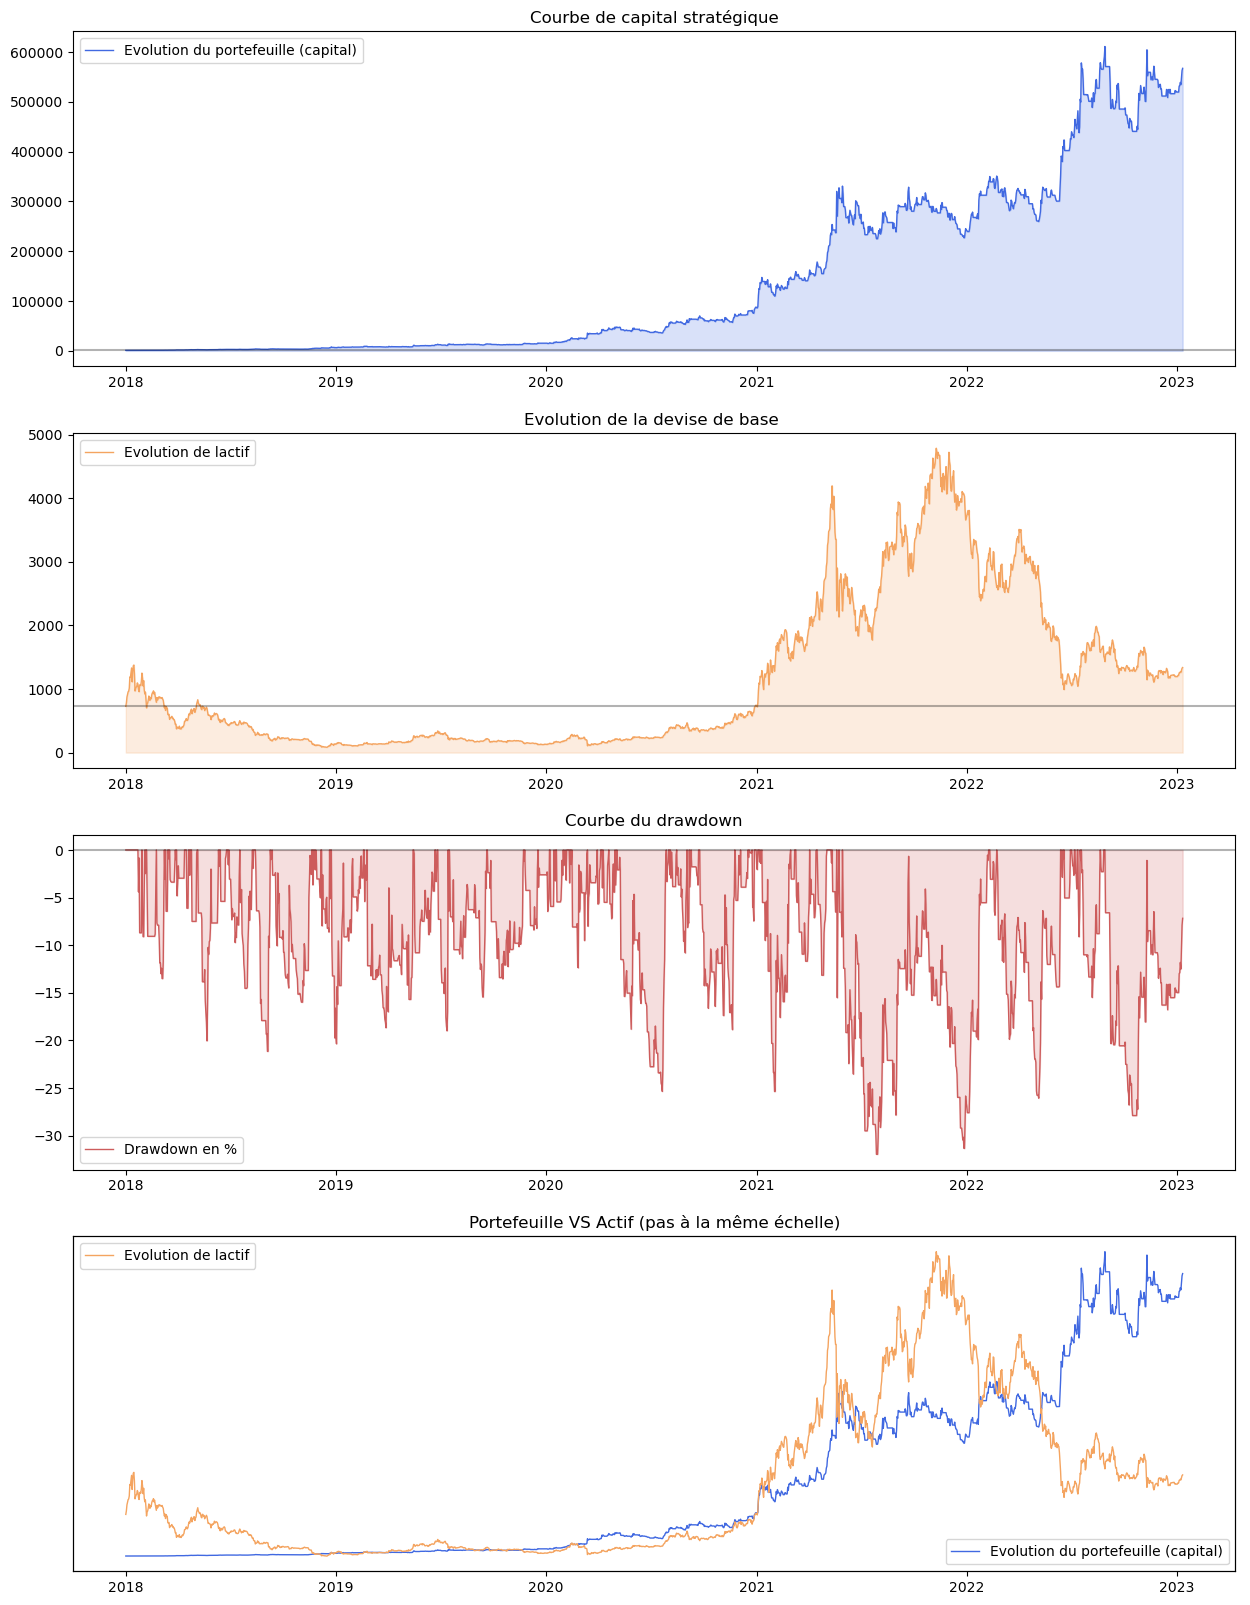

In [4]:
# Paramètres à modifier pour la stratégie
strat = BolTrend(
    df = df.loc["2018":],
    type=["long", "short"],
    bol_window = 100,
    bol_std = 2.2,
    min_bol_spread = 0,
    long_ma_window = 500
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, maker_fee=0.00017, taker_fee=0.00051)
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)

<H2>Courbe de surapprentissage</H2>

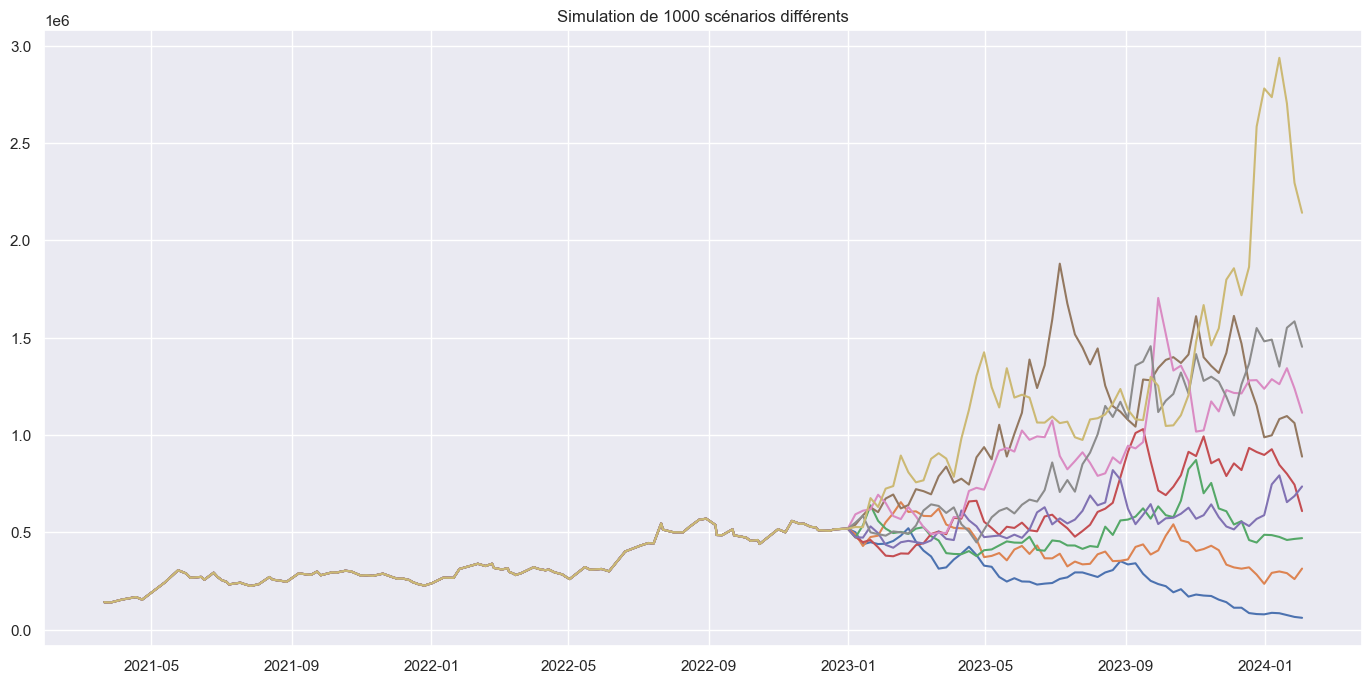

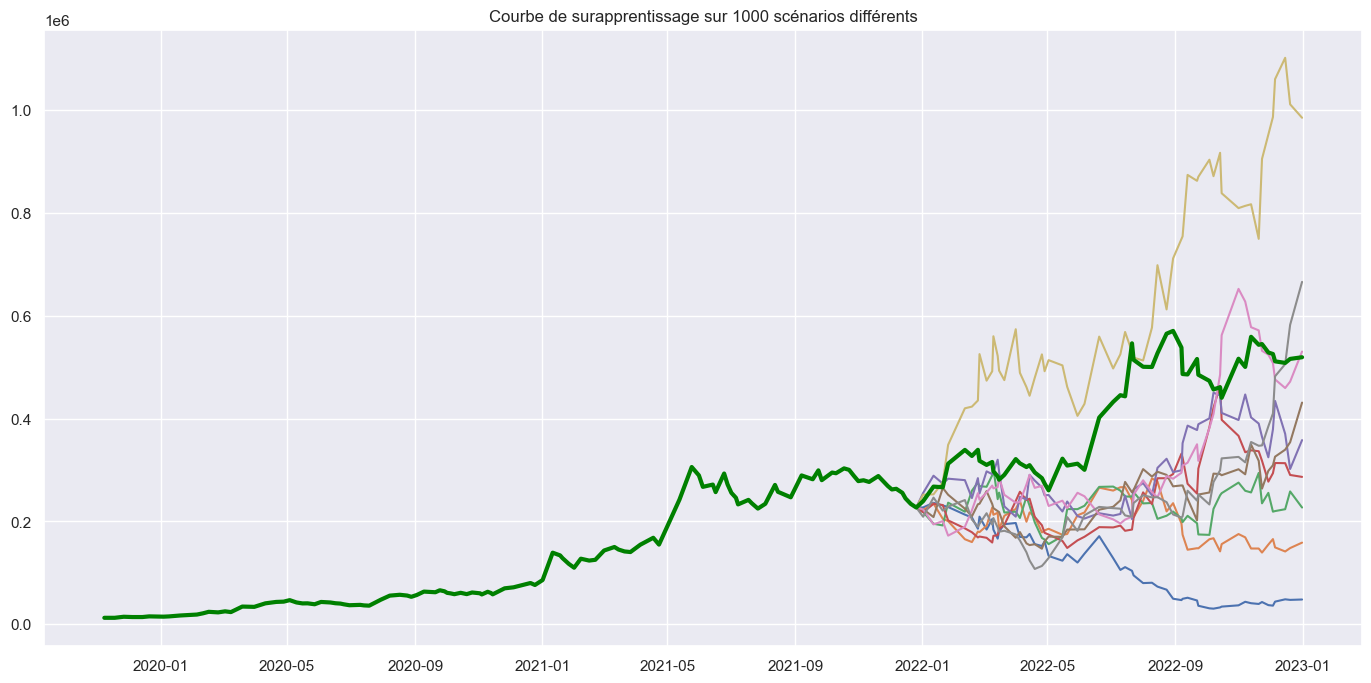

In [5]:
# Simulation de divers scénarios futurs
plot_futur_simulations(
    df_trades=df_trades,
    trades_multiplier=3,
    trades_to_forecast=60,
    number_of_simulations=1000,
    true_trades_to_show=100,
    show_all_simulations=False
)

# Comparaison entre les divers scénarios et la réalité pour voir si il y a du surapprentissage
plot_train_test_simulation(
    df_trades=df_trades,
    train_test_date="2022-01-01",
    trades_multiplier=3,
    number_of_simulations=1000,
)

----- 2018 Cumulative Performances: 563.42%--


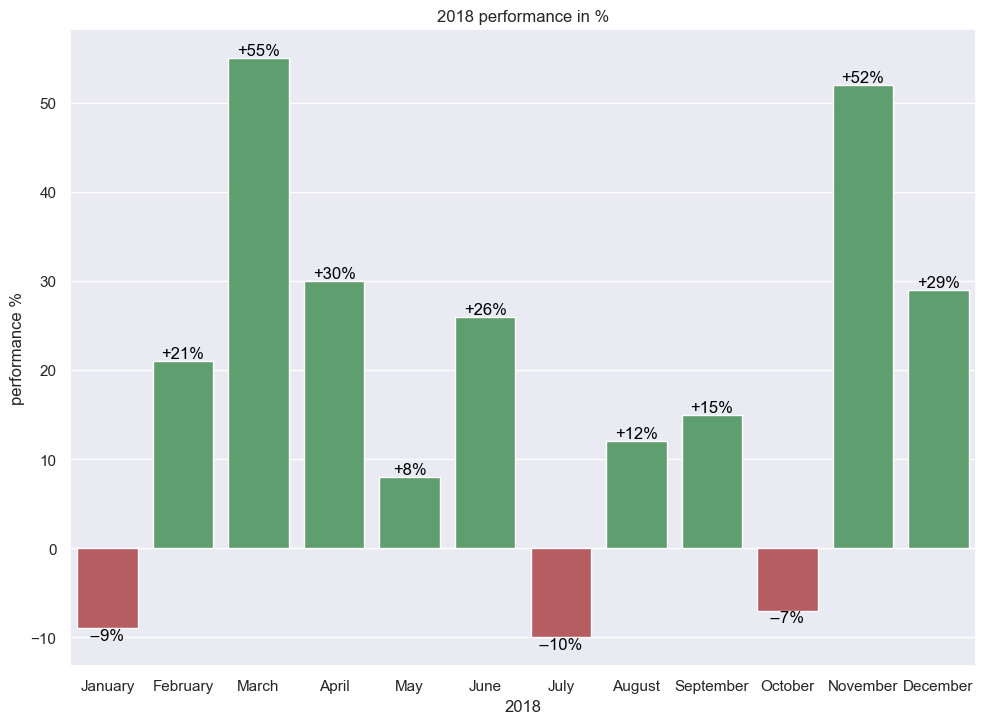

----- 2019 Cumulative Performances: 139.49%--


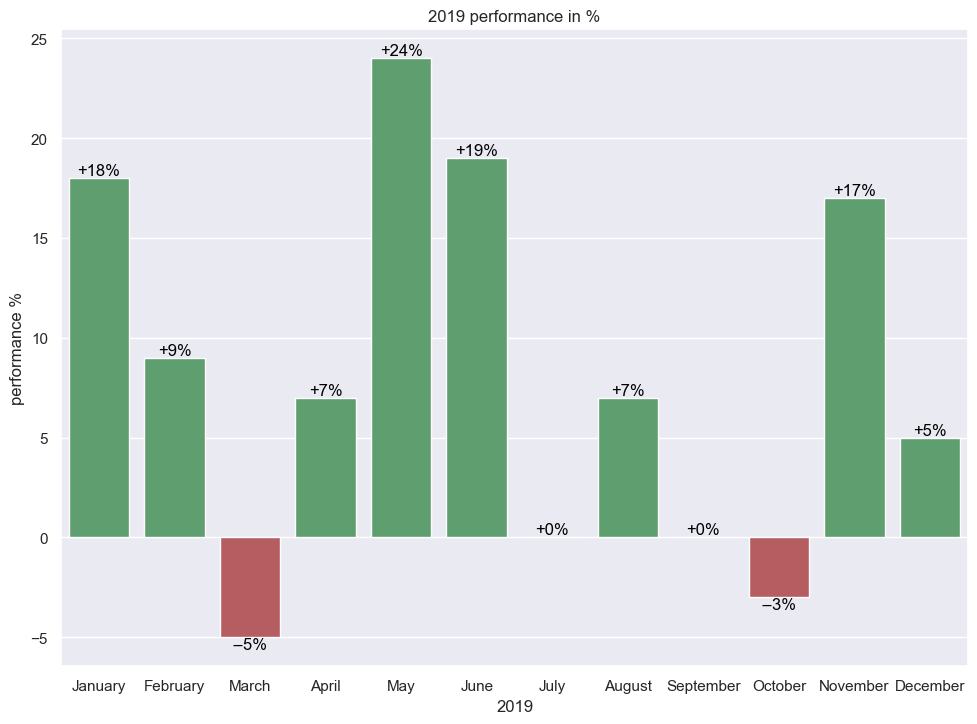

----- 2020 Cumulative Performances: 473.03%--


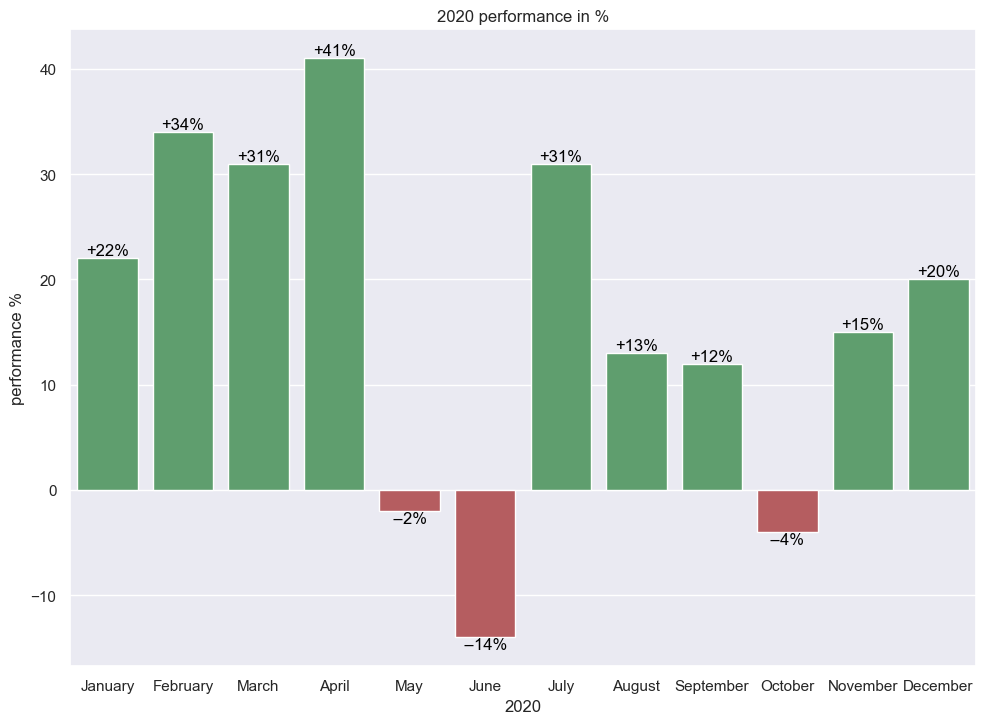

----- 2021 Cumulative Performances: 180.76%--


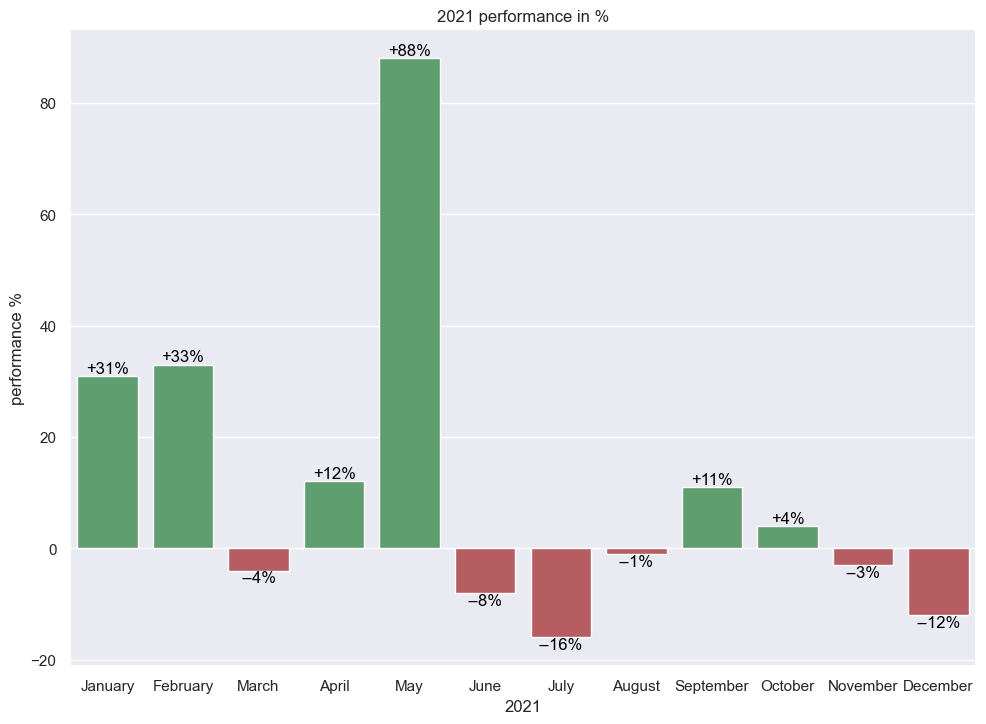

----- 2022 Cumulative Performances: 115.63%--


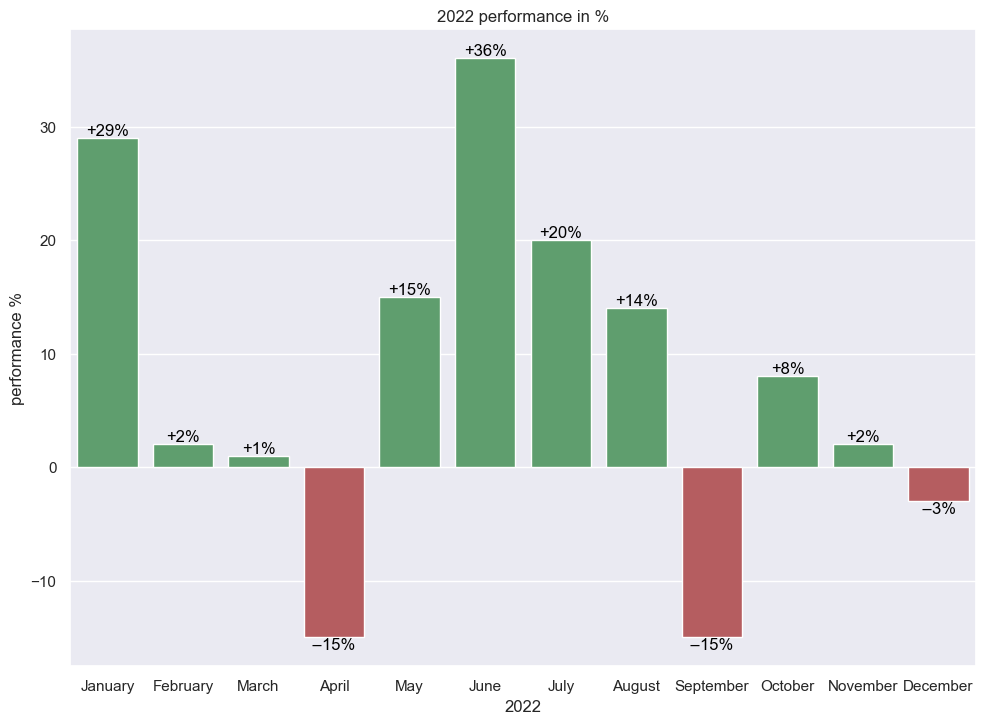

----- 2023 Cumulative Performances: 9.17%--


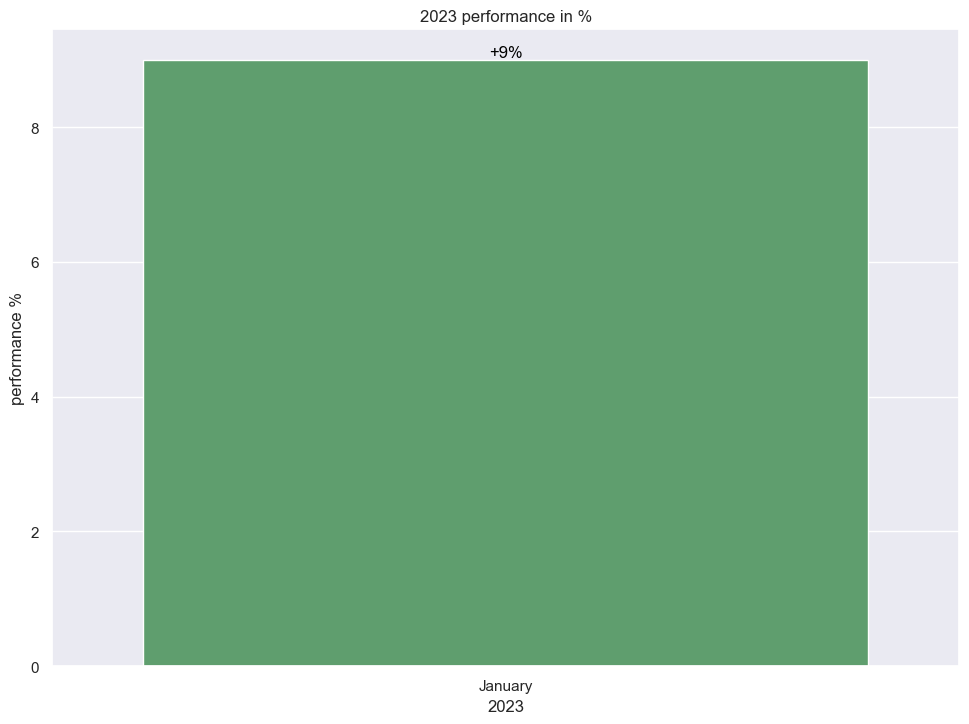

In [6]:
plot_bar_by_month(df_days=df_days)

<H2>Optimisation des paramètres</H2>

In [7]:
# Optimisation des paramètres de la stratégie bol_trend sur le sharpe ratio
%%cython
import cython
from math import ceil
from IPython.display import clear_output
import time
from math import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

dt = None
dt = pd.DataFrame(columns = ['bol_window', 'bol_std', 'long_ma', 'sharpe_ratio', 'win_rate'])

#bol window
loopI = [30,115,5]
#loopI = [20,30,5]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

#bol std
loopJ = [10,30,5]
#loopJ = [10,30,5]
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

#long ma
loopK = [300,800,50]
#loopK = [300,400,50]
enumK = ceil((loopK[1] - loopK[0]) / loopK[2])

count = 0
maxCount = enumI * enumJ * enumK
for i in range(loopI[0], loopI[1], loopI[2]):
    for j in range(loopJ[0], loopJ[1], loopJ[2]):
         for k in range(loopK[0], loopK[1], loopK[2]):
            new_bol_std=j/10
            clear_output(wait=True)
            count += 1
            print("Loading...",count,'/',maxCount)

            # Paramètres à modifier pour la stratégie
            strat = BolTrend(
                df = df.loc["2020":],
                type=["long","short"],
                bol_window = i,
                bol_std = new_bol_std,
                min_bol_spread = 0,
                long_ma_window = k,
            )

            strat.populate_indicators()
            strat.populate_buy_sell()
            bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, maker_fee=0.00017, taker_fee=0.00051)
            myrow = {'bol_window': i, 'bol_std': new_bol_std, 'long_ma': k, 'sharpe_ratio': bt_result['sharpe_ratio'], 'win_rate': bt_result['win_rate']*100}
            myrow = pd.DataFrame(myrow, index=[0])
            dt = pd.concat([dt, myrow], ignore_index=True)   

""" fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dt['bol_window'], dt['bol_std'], dt['long_ma'], c=dt['sharpe_ratio'],cmap='OrRd', s=30)
plt.show() """

dt = dt.sort_values(by=['sharpe_ratio','win_rate'], ascending=False)
dt.to_csv("optimizer_ETH_1h_v1.csv", index=False)
print(dt)

UsageError: Line magic function `%%cython` not found.


In [8]:
import scipy.optimize as optimize
import time

def optimize_strategy(parameters):
    # Récupération des paramètres
    bol_window, bol_std, long_ma_window = parameters

    # Initialisation de la stratégie avec les paramètres
    strat = BolTrend(
        df = df.loc["2020":],
        type=["long","short"],
        bol_window = bol_window,
        bol_std = bol_std,
        min_bol_spread = 0,
        long_ma_window = long_ma_window,
    )

    # Exécution de la stratégie
    strat.populate_indicators()
    strat.populate_buy_sell()
    bt_result = strat.run_backtest(initial_wallet=1000, leverage=1, maker_fee=0.00017, taker_fee=0.00051)

    # Calcul du ratio Sharpe
    sharpe_ratio = bt_result['sharpe_ratio']

    # Inversion du ratio Sharpe pour maximiser la valeur (la fonction minimize minimise la valeur)
    return -sharpe_ratio


# Définition des valeurs initiales des paramètres
x0 = [100, 2.25, 500]
bounds = [(50, 120), 
          (1.0, 3.5),
          (200, 800),]

# Exécution de l'optimisation pour chaque combinaison de valeurs initiales
results = []

# Début du chronomètre
start_time = time.time()
result = optimize.minimize(optimize_strategy, x0, bounds=bounds)
results.append(result)
end_time = time.time()
print(f"Temps d'exécution : {end_time - start_time:.2f} secondes")

# Récupération des meilleurs paramètres
best_result = min(results, key=lambda x: x.fun)
bol_window, bol_std, long_ma_window = best_result.x
print(f"Les meilleurs paramètres sont: bol_window={bol_window}, bol_std={bol_std}, long_ma_window={long_ma_window}")


Temps d'exécution : 4.54 secondes
Les meilleurs paramètres sont: bol_window=100.0, bol_std=2.25, long_ma_window=500.0


<H2>Test performances Cython</H2>

In [9]:
%load_ext Cython

In [10]:
%%cython
import cython
from libc.math cimport exp, sqrt, pow, log, erf

@cython.cdivision(True)
@cython.boundscheck(False)
cpdef double std_norm_cdf(double x):
    return 0.5*(1+erf(x/sqrt(2)))

@cython.cdivision(True)
@cython.boundscheck(False)
cpdef double black_scholes(double s, double k, double t, double v, double rf, double div, int cp):
    d1 = (log(s/k)+(rf-div+0.5*pow(v,2))*t)/(v*sqrt(t))
    d2 = d1 - v*sqrt(t)
    optprice = cp*s*exp(-div*t)*std_norm_cdf(cp*d1) - cp*k*exp(-rf*t)*std_norm_cdf(cp*d2)
    return optprice

In [11]:
from math import exp, sqrt, pow, log, erf

def std_norm_cdf_py(x):
    return 0.5*(1+erf(x/sqrt(2.0)))

def black_scholes_py(s, k, t, v, rf, div, cp):
    """Price an option using the Black-Scholes model.
    
    s : initial stock price
    k : strike price
    t : expiration time
    v : volatility
    rf : risk-free rate
    div : dividend
    cp : +1/-1 for call/put
    """
    d1 = (log(s/k)+(rf-div+0.5*pow(v,2))*t)/(v*sqrt(t))
    d2 = d1 - v*sqrt(t)
    optprice = cp*s*exp(-div*t)*std_norm_cdf_py(cp*d1) - \
        cp*k*exp(-rf*t)*std_norm_cdf_py(cp*d2)
    return optprice

In [ ]:
%timeit black_scholes_cy(100.0, 100.0, 1.0, 0.3, 0.03, 0.0, -1)
%timeit black_scholes_py(100.0, 100.0, 1.0, 0.3, 0.03, 0.0, -1)

<H2>Tests divers</H2>

<AxesSubplot: xlabel='date'>

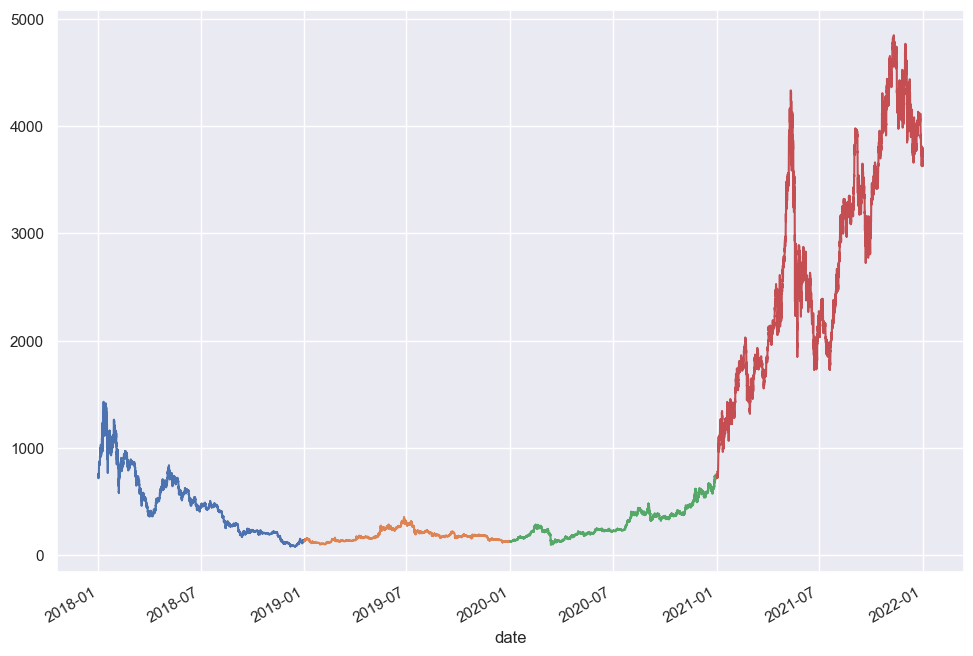

In [13]:
df.loc['2018-01-01':'2018-12-31', 'close' ].plot()
df.loc['2019-01-01':'2019-12-31', 'close' ].plot()
df.loc['2020-01-01':'2020-12-31', 'close' ].plot()
df.loc['2021-01-01':'2021-12-31', 'close' ].plot()

<H2>Anaylse Bull et Bear Market</H2>

In [16]:
raw_data_btc=pd.read_csv('../../../database/top_100//bitcoin.csv')
raw_data_eth=pd.read_csv('../../../database/top_100//ethereum.csv')

def date_format(df):
    if isinstance(df, pd.DataFrame):
        if 'Date' in df.columns:
            df.Date = pd.to_datetime(df.Date)
            df[['Year','Month','Day']] = df.Date.apply(lambda x: pd.Series(x.strftime("%Y-%m-%d").split("-")))
    else:
        print("Invalid entry, please use a data frame with a Date column.")
    return df

data=date_format(raw_data_btc)
data['Close']=data['Close'].astype(float)
data['Open']=data['Open'].astype(float)
data['High']=data['High'].astype(float)
data['Low']=data['Low'].astype(float)
data['Year']=data['Year'].astype(int)
data['Month']=data['Month'].astype(int)
data['Day']=data['Day'].astype(int)

data_eth=date_format(raw_data_eth)
data_eth['Close']=data_eth['Close'].astype(float)
data_eth['Open']=data_eth['Open'].astype(float)
data_eth['High']=data_eth['High'].astype(float)
data_eth['Low']=data_eth['Low'].astype(float)
data_eth['Year']=data_eth['Year'].astype(int)
data_eth['Month']=data_eth['Month'].astype(int)
data_eth['Day']=data_eth['Day'].astype(int)


In [18]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Ohlc(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close']))

fig.update_layout(template='plotly_dark',
    height = 550,
    title='Prix BTC au fil des ans',
    xaxis_title="Années",
    yaxis_title='Prix BTC',title_x=0.5,
    shapes = [dict(x0='2017-09-01', x1='2017-09-01', y0=0, y1=1, xref='x', yref='paper',line_width=2),
              dict(x0='2018-01-10', x1='2018-01-10', y0=0, y1=1, xref='x', yref='paper',line_width=2),
              dict(x0='2020-11-01', x1='2020-11-01', y0=0, y1=1, xref='x', yref='paper',line_width=2),
             dict(x0='2021-05-01', x1='2021-05-01', y0=0, y1=1, xref='x', yref='paper',line_width=2)],
    annotations=[dict(x='2017-01-01', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bull🐂'),
        dict(x='2018-01-10', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bear🐻'),
        dict(x='2020-11-01', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bull🐂'),
        dict(x='2021-08-01', y=0.05, xref='x', yref='paper',showarrow=False, xanchor='left', text='bear🐻')],
    updatemenus=[
        dict(type='buttons',
             buttons=[dict(label='Linear', method='relayout',args=[{'yaxis.type': 'linear'}]),
                      dict(label='Log', method='relayout', args=[{'yaxis.type': 'log'}])],
                      x=0, y=1.3, bgcolor = 'gray', bordercolor = 'blue', borderwidth = 2, font = dict(color = 'black')
            )]
)

fig.update_yaxes(
    tickprefix="$", showgrid=True
)

fig.update_xaxes(
     showgrid=True
)

fig.show()